Three criteria were defined for BDT score when training, corresponding to fake rate at 1%, 0.1% and 0.01% as *loose, medium and tight*. They are:
- [**loose**] 0.9512947797775269
- [**medium**] 4.848821640014648
- [**tight**] 8.108936309814453

This notebook counts the weighted counts passing the combinations of these criteria.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

########## backgrounds ##########
bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))
bkgscales_=json.load(open('../../MC/Samples/backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        files = bkgdatasets_[group][tag]
        bkgdatasets[tag] = {'files': files, 'treename': 'ffNtuples/ffNtuple'}
        if tag=='TTJets': bkgdatasets[tag]['treename'] = 'ffNtuplizer/ffNtuple'

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 60.432*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('../Samples/control_data2018.json'))
datadatasets = dict(
    A={'files': datadatasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datadatasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datadatasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datadatasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

In [4]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "control region")
        count_axis = hist.Bin("count", "#pass BDT threshold", 9, 0, 9)
        self._accumulator = processor.dict_accumulator({
            'count': hist.Hist("Counts", dataset_axis, count_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            mva=df['pfjet_mva'],
        )
        ## apply metfilters ##
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leadingLjPair = leadingLjPair[controlregion]
            looseval = 0.9512947797775269
            mediumval = 4.848821640014648
            tightval = 8.108936309814453
            passloosecounts = (leadingLjPair.i0.mva>looseval).astype(int)+(leadingLjPair.i1.mva>looseval).astype(int)
            passmediumcounts = (leadingLjPair.i0.mva>mediumval).astype(int)+(leadingLjPair.i1.mva>mediumval).astype(int)
            passtightcounts = (leadingLjPair.i0.mva>tightval).astype(int)+(leadingLjPair.i1.mva>tightval).astype(int)
            
            output['count'].fill(dataset=dataset, count=passloosecounts.flatten())
            output['count'].fill(dataset=dataset, count=(passmediumcounts.flatten()+3))
            output['count'].fill(dataset=dataset, count=(passtightcounts.flatten()+6))

        return output
    
    def postprocess(self, accumulator):
        # scale
        accumulator['count'].scale(bkgscales, axis='dataset')
        # cat grouping
        accumulator['count_cat'] = accumulator['count'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5366/5366 [04:45<00:00, 18.79items/s]


/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:313: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:313: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:320: RuntimeWarning: divide by zero encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:320: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:33: RuntimeWarning:

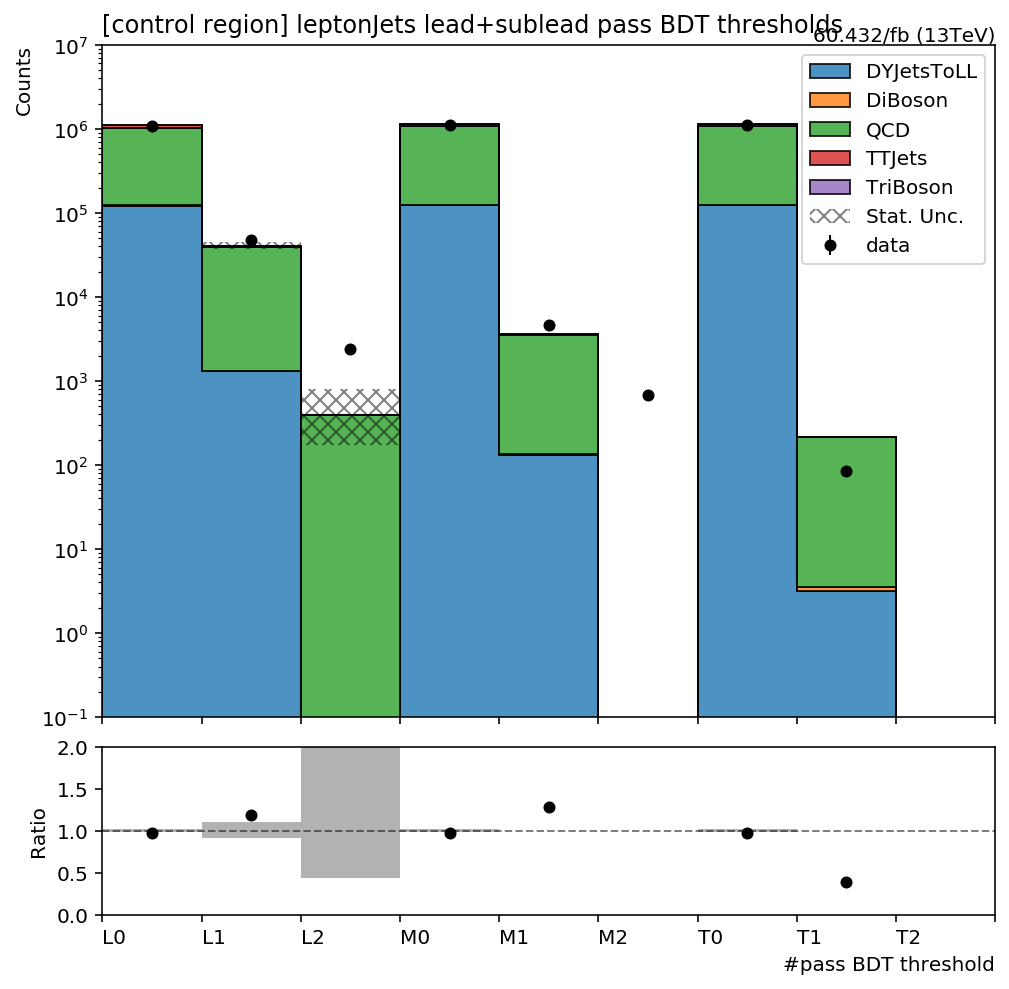

In [6]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

hist.plot1d(output['count_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['count_cat']['data'],
           overlay='cat',
           ax=ax,
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1e-1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['count_cat']['data'].sum('cat'), output['count_cat'][notdata].sum('cat'),
              ax=rax,
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xticklabels(['L0', 'L1', 'L2', 'M0', 'M1', 'M2', 'T0', 'T1', 'T2'],fontdict={'ha': 'left'})
rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets lead+sublead pass BDT thresholds', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

---